In [1]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
sns.set(font_scale=2)

import warnings
warnings.filterwarnings("ignore")

## Two-way ANOVA

Вспомним ещё раз про Two-way ANOVA.

Изучим влияние витамина C на рост зубов у морских свинок ;)

![](https://homkin.ru/wp-content/uploads/2018/07/23-1-e1530703517235.jpg)

У нас есть три переменные:

  1. `len` - длина зубов;
  2. `supp` - VC(ascorbic acid)/OJ(Orange Juice);
  3. `dose` - доза.

In [2]:
datafile = "ToothGrowth.csv"
data = pd.read_csv(datafile)
data = data.reset_index()

In [3]:
data.head()

,index,Unnamed: 0,len,supp,dose
0,0,1,4.2,VC,0.5
1,1,2,11.5,VC,0.5
2,2,3,7.3,VC,0.5
3,3,4,5.8,VC,0.5
4,4,5,6.4,VC,0.5


Построим график взаимодействия(interaction plot).

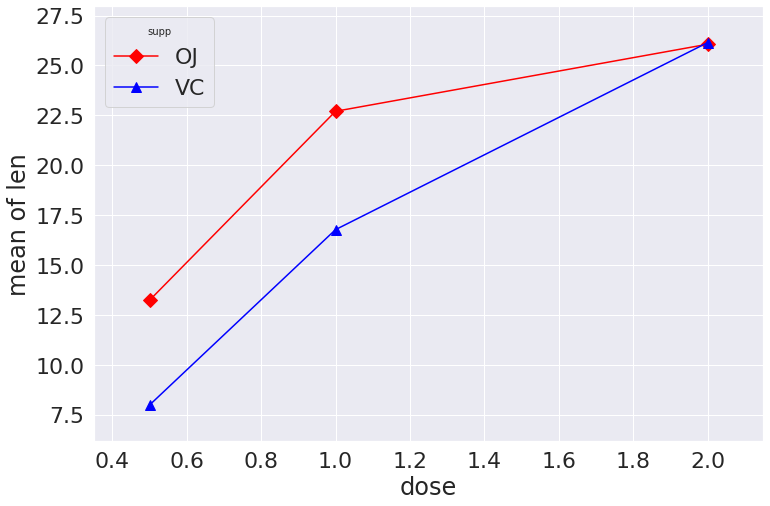

In [4]:
fig = interaction_plot(data.dose, 
                       data.supp, 
                       data.len,
                       colors=['red','blue'], markers=['D','^'], ms=10)
fig.set_figheight(8)
fig.set_figwidth(12)

### Handmade ANOVA

Посчитаем все константы и степени свободы.

In [5]:
N = len(data.len)
df_a = len(data.supp.unique()) - 1 # степени свободы по первому фактору
df_b = len(data.dose.unique()) - 1 # степени свободы по второму фактору
df_axb = df_a * df_b 
df_w = N - (len(data.supp.unique()) * len(data.dose.unique()))

Среднее по всем наблюдениям.

In [6]:
grand_mean = data['len'].mean()

Сумма ошибок между групповыми средними и общим средним.

In [7]:
ssq_a = sum([(data[data.supp==l].len.mean() - grand_mean)**2 for l in data.supp])

In [8]:
ssq_b = sum([(data[data.dose==l].len.mean()-grand_mean)**2 for l in data.dose])

Сумма ошибок между общим средним и измерениями. 

In [9]:
ssq_t = sum((data.len - grand_mean)**2)

Сумма ошибок между групповыми средними и измерениями.

In [10]:
vc = data[data.supp == 'VC']
oj = data[data.supp == 'OJ']
vc_dose_means = [vc[vc.dose == d].len.mean() for d in vc.dose]
oj_dose_means = [oj[oj.dose == d].len.mean() for d in oj.dose]
ssq_w = sum((oj.len - oj_dose_means)**2) +sum((vc.len - vc_dose_means)**2)

![](https://www.marsja.se/wp-content/uploads/2016/03/two-way-anova-sum-of-squares.png)

In [11]:
ssq_axb = ssq_t - ssq_a - ssq_b - ssq_w

In [12]:
ms_a = ssq_a / df_a

In [13]:
ms_b = ssq_b / df_b

In [14]:
ms_axb = ssq_axb / df_axb

In [15]:
ms_w = ssq_w / df_w

### F-статистики

In [16]:
f_a = ms_a / ms_w
f_b = ms_b / ms_w
f_axb = ms_axb / ms_w

### Посчитаем p-values

In [17]:
stats.f?

In [18]:
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)

In [19]:
results = {
    'sum_sq': [ssq_a, ssq_b, ssq_axb, ssq_w],
    'df': [df_a, df_b, df_axb, df_w],
    'F': [f_a, f_b, f_axb, 'NaN'],
    'PR(>F)':[p_a, p_b, p_axb, 'NaN']
}

columns = ['sum_sq', 'df', 'F', 'PR(>F)']
 
aov_table1 = pd.DataFrame(results, 
                          columns=columns,
                          index=['supp', 'dose', 
                                 'supp:dose', 'Residual'])

### Немного дополнительных показателей связанных с величиной эффекта

  1. $\eta^2$, что-то вроде $R^2$ в регрессии.

$$\eta^2 = SSbetween / SStotal = SSB / SST$$

Классические эмпирические интерпретации $\eta^2$:

  * .02 ~ малая выраженность эффекта;
  * .13 ~ средняя выраженность эффект;
  * .26 ~ сильная выраженность эффекта.
  
  
  2. $\omega^2$ 
  
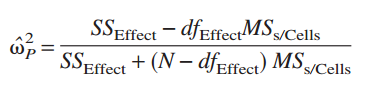

In [20]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq'] / sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1] / aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq'] - (aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


eta_squared(aov_table1)
omega_squared(aov_table1)
aov_table1

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
supp,205.350000,1,15.572,0.000231183,0.059484,0.055452
dose,2426.434333,2,92,4.04629e-18,0.702864,0.692579
supp:dose,108.319000,2,4.10699,0.0218603,0.031377,0.023647
Residual,712.106000,54,NaN,NaN,NaN,NaN


### ANOVA from `statsmodels`

In [21]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

In [22]:
eta_squared(aov_table)
omega_squared(aov_table)
aov_table

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(supp),205.350000,1.0,15.571979,2.311828e-04,0.059484,0.055452
C(dose),2426.434333,2.0,91.999965,4.046291e-18,0.702864,0.692579
C(supp):C(dose),108.319000,2.0,4.106991,2.186027e-02,0.031377,0.023647
Residual,712.106000,54.0,NaN,NaN,NaN,NaN


### Q-Q график

Очень важно проверять, что остатки распределены нормально.

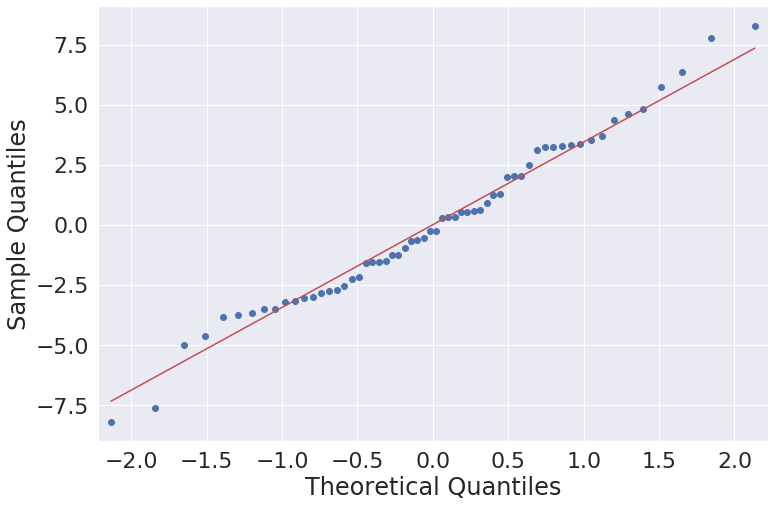

In [23]:
import statsmodels.api as sm

res = model.resid 
fig = sm.qqplot(res, line='s')
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

##### Критерий Шапиро-Уилка для проверки нормальности

In [24]:
stats.shapiro(res)

(0.9849883913993835, 0.6694232821464539)

## Repeated Measures ANOVA

$$\mathbb{H}_0:~~\textrm{все средние равны для каждой "repeated-measured" категории}$$  $$~~\mathrm{vs}~~$$  $$\mathbb{H}_1: ~~ \textrm{не все средние равны}$$

In [25]:
from statsmodels.stats.anova import AnovaRM

In [26]:
AnovaRM?

In [27]:
df1way = pd.read_csv('rmAOV1way.csv')

In [28]:
df1way.head()

,Sub_id,rt,cond
0,1,971.826563,noise
1,2,857.608167,noise
2,3,1035.354758,noise
3,4,867.620871,noise
4,5,928.381831,noise


In [29]:
np.unique(df1way.cond, return_counts=True)

(array(['noise', 'quiet'], dtype=object), array([60, 60]))

In [30]:
print(np.unique(df1way.Sub_id, return_counts=True))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))


### One-way RANOVA

In [31]:
aovrm1way = AnovaRM(df1way, 'rt', 'Sub_id', within=['cond'])
res1way = aovrm1way.fit()

print(res1way)

               Anova
     F Value  Num DF  Den DF Pr > F
-----------------------------------
cond 499.1549 1.0000 59.0000 0.0000



### Two-way RANOVA

In [32]:
df2way = pd.read_csv('rmAOV2way.csv')

In [33]:
df2way.head()

,Sub_id,rt,iv1,iv2
0,1,1082.986553,noise,down
1,2,938.799689,noise,down
2,3,1101.470970,noise,down
3,4,1123.030275,noise,down
4,5,938.051589,noise,down


In [34]:
np.unique(df2way.iv2, return_counts=True)

(array(['down', 'middle', 'up'], dtype=object), array([120, 120, 120]))

In [35]:
np.unique(df2way.Sub_id, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]))

In [36]:
aovrm2way = AnovaRM(df2way, 'rt', 'Sub_id', within=['iv1', 'iv2'])
res2way = aovrm2way.fit()

print(res2way)

                 Anova
         F Value  Num DF  Den DF  Pr > F
----------------------------------------
iv1     2207.0162 1.0000  59.0000 0.0000
iv2      275.4144 2.0000 118.0000 0.0000
iv1:iv2    1.8651 2.0000 118.0000 0.1594



Мы могли бы посмотреть на эффект только от одной переменной...

In [37]:
aovrm2way = AnovaRM(df2way, 'rt', 'Sub_id', within=['iv1'])
res2way = aovrm2way.fit()

print(res2way)

ValueError: The data set contains more than one observation per subject and cell. Either aggregate the data manually, or pass the `aggregate_func` parameter.

Но сначала нужно указать способ аггрегации повторяющихся значений.

In [38]:
aovrm2way = AnovaRM(df2way, 'rt', 'Sub_id', within=['iv1'], 
                    aggregate_func='mean')
res2way = aovrm2way.fit()

print(res2way)

               Anova
     F Value  Num DF  Den DF Pr > F
-----------------------------------
iv1 2207.0162 1.0000 59.0000 0.0000



In [39]:
aovrm2way = AnovaRM(df2way, 'rt', 'Sub_id', within=['iv1'], 
                    aggregate_func=np.median)
res2way = aovrm2way.fit()

print(res2way)

              Anova
    F Value  Num DF  Den DF Pr > F
----------------------------------
iv1 992.1661 1.0000 59.0000 0.0000



### Используя `spm1d`

http://www.spm1d.org/

Дано: 10 субъектами.

Измеряем силу давления на землю при ходьбе.

Три режима ходьбы: 
  1. Медленный шаг;
  2. Средняя скорость шага;
  3. Высокая скорость шага;


Данные представляют собой силу давления в зависимости от фазы "нажатия на землю"(stance phase) нормированное на вес человека.

Мы изучаем систематические эффекты между разными субъектами.

![](https://www.researchgate.net/profile/Bir_Bhanu/publication/232616246/figure/fig1/AS:300534557888515@1448664430529/Gait-cycle-expressed-by-swing-phase-and-stance-phase.png)

In [40]:
!pip install spm1d

     |████████████████████████████████| 8.5MB 3.6MB/s eta 0:00:01


In [41]:
import spm1d

In [42]:
#(0) Load data:
dataset = spm1d.data.uv1d.anova1rm.SpeedGRFcategoricalRM()
Y, A, SUBJ = dataset.get_data()

In [43]:
SUBJ

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9])

In [44]:
A

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [45]:
#(1) ANOVA:
alpha = 0.05
equal_var = True
F = spm1d.stats.anova1(Y, A, equal_var)
Frm = spm1d.stats.anova1rm(Y, A, SUBJ, equal_var)
Fi = F.inference(alpha)
Firm = Frm.inference(alpha)

In [46]:
Fi

SPM{F} inference field
   SPM.effect    :   Main A
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (2, 27)
   SPM.fwhm      :  6.53098
   SPM.resels    :  (1, 15.31164)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  8.73139
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (<0.001, <0.001, 0.017)



In [47]:
Firm

SPM{F} inference field
   SPM.effect    :   Main A
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (2, 18)
   SPM.fwhm      :  5.88283
   SPM.resels    :  (1, 16.99861)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  10.41185
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (<0.001, <0.001, <0.001, <0.001)



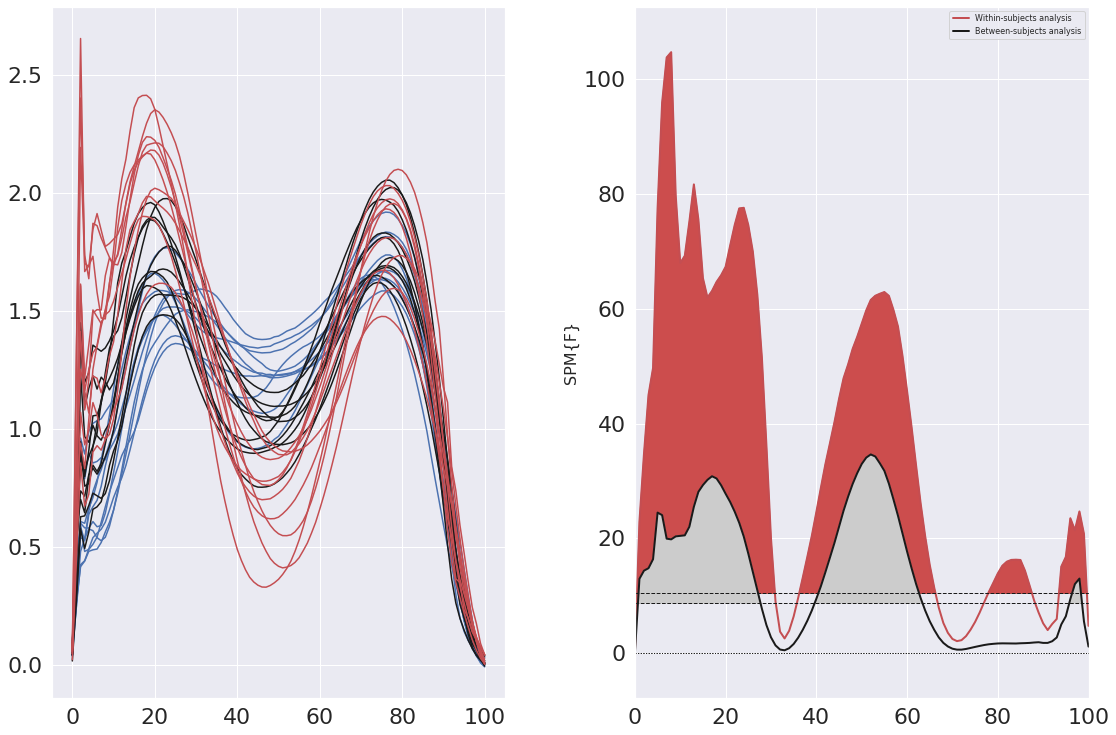

In [48]:
#(2) Plot:
plt.close('all')
plt.figure( figsize=(18, 12) )
ax0 = plt.axes((0.1, 0.15, 0.35, 0.8))
ax1 = plt.axes((0.55, 0.15, 0.35, 0.8))

### plot mean subject trajectories:
ax0.plot(Y[A==0].T, 'b')
ax0.plot(Y[A==1].T, 'k')
ax0.plot(Y[A==2].T, 'r')

### plot SPM results:
Firm.plot(ax=ax1, 
          color='r', 
          facecolor=(0.8,0.3,0.3), 
          label='Within-subjects analysis')

Fi.plot(ax=ax1, label='Between-subjects analysis')

ax1.legend(fontsize=8)

plt.show()

## Random effects analysis

Отойдём немного от ANOVA :)

Text(0, 0.5, 'GRF (BW)')

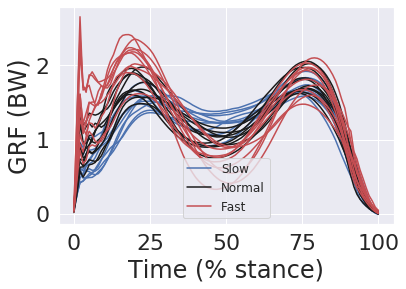

In [49]:
nSubj = 10
Y1, Y2, Y3 = [], [], []
for subj in range(10):
    dataset = spm1d.data.uv1d.anova1.SpeedGRFcategorical(subj=subj)
    Y, A = dataset.get_data()
    y1, y2, y3 = Y[A==1], Y[A==2], Y[A==3] 
    Y1.append(y1.mean(axis=0))
    Y2.append(y2.mean(axis=0))
    Y3.append(y3.mean(axis=0))

Y1, Y2, Y3 = np.asarray(Y1), np.asarray(Y2), np.asarray(Y3)


# plot:
plt.close('all')
h1 = plt.plot(Y1.T, color='b')
h2 = plt.plot(Y2.T, color='k')
h3 = plt.plot(Y3.T, color='r')
h1[0].set_label('Slow')
h2[0].set_label('Normal')
h3[0].set_label('Fast')
plt.legend(loc='lower center', fontsize=12)
plt.xlabel('Time (% stance)')
plt.ylabel('GRF (BW)')
# plt.show()

#### Level 1 Analysis

Зафитируем для каждого субъекта кривую отклика от времени

$$y = \beta_0 x + \beta_1 + \epsilon$$

И построим график $\beta_0$ от времени.

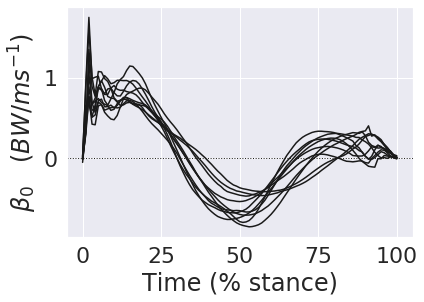

In [50]:
#first-level SPM analysis: (within-subject effects)
nSubj = 10
BETA = []  #regression slopes
for subj in range(nSubj):
    dataset = spm1d.data.uv1d.regress.SpeedGRF(subj=subj)
    Y, x = dataset.get_data()
    t = spm1d.stats.regress(Y, x) #conduct linear regression
    BETA.append(t.beta[0])  #retrieve the regression slope
BETA = np.array(BETA)


#plot:
plt.close('all')
ax = plt.axes((0.15, 0.15, 0.8, 0.8))
plt.plot(BETA.T, color='k')
ax.axhline(y=0, color='k', linewidth=1, linestyle=':')
ax.set_xlabel('Time (% stance)')
ax.set_ylabel(r'$\beta_0$   $(BW / ms^{-1})$')
plt.show()

Видно, что нулевая гипотез о независимости скорее всего неверна.


#### Level 2 Analysis

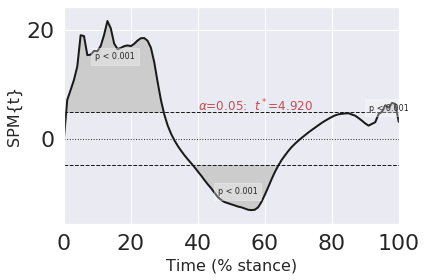

In [51]:
#first-level SPM analysis: (within-subject effects)
nSubj = 10
BETA = []  #regression slopes
for subj in range(nSubj):
    dataset = spm1d.data.uv1d.regress.SpeedGRF(subj=subj)
    Y, x = dataset.get_data()
    t = spm1d.stats.regress(Y, x) #conduct linear regression
    BETA.append(t.beta[0])  #retrieve the regression slope

BETA = np.array(BETA)

#second-level SPM analysis:  (between-subject random effects)
alpha = 0.05
t = spm1d.stats.ttest(BETA)
ti = t.inference(alpha, two_tailed=True)

#plot:
plt.close('all')
ti.plot()
ti.plot_threshold_label(fontsize=12)
ti.plot_p_values()
plt.xlabel('Time (% stance)', size=16)
plt.show()

### Linear Mixed Models

In [52]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

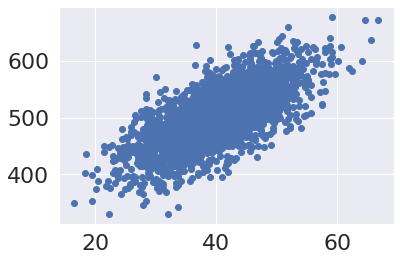

In [53]:
# сгенерируем коррелированные данные
xx = np.array([-30.0, 110.0])
yy = np.array([0., 1000.0])

means = [xx.mean(), yy.mean()]  

stds = [xx.std() / 10, yy.std() / 10]
corr = 0.7         # корреляция

covs = [[stds[0]**2 , stds[0] * stds[1] * corr],
        [stds[0]*stds[1] * corr, stds[1]**2]]

m = np.random.multivariate_normal(means, covs, 2500).T
plt.scatter(m[0], m[1])

In [54]:
# категориальная переменная 
cities = np.random.randint(0, 50, 2500)

# бинарная переменная
kids =  np.random.randint(0, 2, 2500)

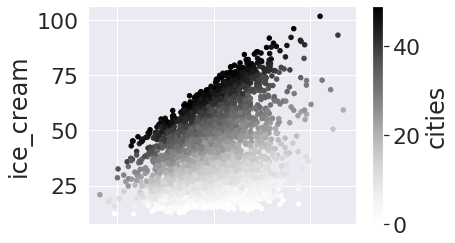

In [55]:
df = pd.DataFrame({'ice_cream': m[1], 
                   'temp': m[0], 
                   'cities': cities, 
                   'kids': kids})

# Предположим, что у разных городов есть разные предпочения
for num in range(50):
    df['ice_cream'][df['cities']==num] += df['temp'] * num

# Если есть дети => больше любят мороженое
df['ice_cream'][df['kids']==1] += df['temp']*1.5

# нормировка
df['ice_cream'] = df['ice_cream'] / 35

df.plot(x='temp', y='ice_cream', kind='scatter', c='cities')

#### Generalized Linear Models

Если мы хотим восстановить вероятность есть ли у человека дети или нет, то фитировать линейную модель может быть не самым умным решением.

А вот фитировать биномиальную модель самое то.

Сделать это в `statsmodels` проще простого указанием `family` - семья распределения на предсказаниях.


Всё отличие от обычных линейных моделей, которые выглядят так:

$$Y = A X + \beta,$$

что GLZ выглядит так:

$$Y = g(AX + \beta),$$

где $g$ - некоторая функция.

Для биномиального распределения:

$$y = \frac{1}{1 + \exp(-AX - \beta)},$$

т.е. обычная сигмоида.

In [56]:
mod1 = smf.glm('kids ~ ice_cream', 
                data=df, family=sm.families.Binomial()).fit()

In [57]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   kids   No. Observations:                 2500
Model:                            GLM   Df Residuals:                     2498
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1730.1
Date:                Fri, 08 Nov 2019   Deviance:                       3460.1
Time:                        12:33:50   Pearson chi2:                 2.50e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2077      0.105     -1.970      0.049      -0.414      -0.001
ice_cream      0.0030      0.002      1.325      0.185      -0.001       0.007
==============================================================================
"""

### Linear Mixed Effects

Пример из интернета:

![](https://hlplab.files.wordpress.com/2011/05/simpsons-paradox.png)

In [58]:
model1 = sm.MixedLM.from_formula("ice_cream ~ temp", 
                                 data=df, 
                                 groups=df["cities"] # вот где она становится mixed!
                                ).fit(reml=False)

In [59]:
model1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: ice_cream 
No. Observations: 2500    Method:             ML        
No. Groups:       50      Scale:              10.3856   
Min. group size:  31      Likelihood:         -6652.3124
Max. group size:  74      Converged:          Yes       
Mean group size:  50.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      8.858    2.375  3.729 0.000  4.203 13.514
temp           0.854    0.009 93.998 0.000  0.836  0.872
Group Var    275.274   17.268                           
========================================================

"""

In [60]:
model2 = sm.MixedLM.from_formula("ice_cream ~ temp", 
                                 data=df, 
                                 re_formula="temp", 
                                 groups=df["cities"]).fit(reml=False)

In [61]:
model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  ice_cream 
No. Observations:  2500     Method:              ML        
No. Groups:        50       Scale:               1.8222    
Min. group size:   31       Likelihood:          -4520.7844
Max. group size:   74       Converged:           Yes       
Mean group size:   50.0                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         8.649    0.156 55.568 0.000  8.344  8.954
temp              0.862    0.059 14.646 0.000  0.746  0.977
Group Var         0.017    0.215                           
Group x temp Cov -0.054    0.055                           
temp Var          0.172    0.026                           
===========================================================

"""

### Nested ANOVA

С искуственными данным

In [62]:
dataset = spm1d.data.uv1d.anova2nested.SPM1D_ANOVA2NESTED_3x3()
Y, A, B = dataset.get_data()

In [63]:
Y.shape, A.shape, B.shape

((45, 101), (45,), (45,))

In [64]:
A

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

In [65]:
B

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8])

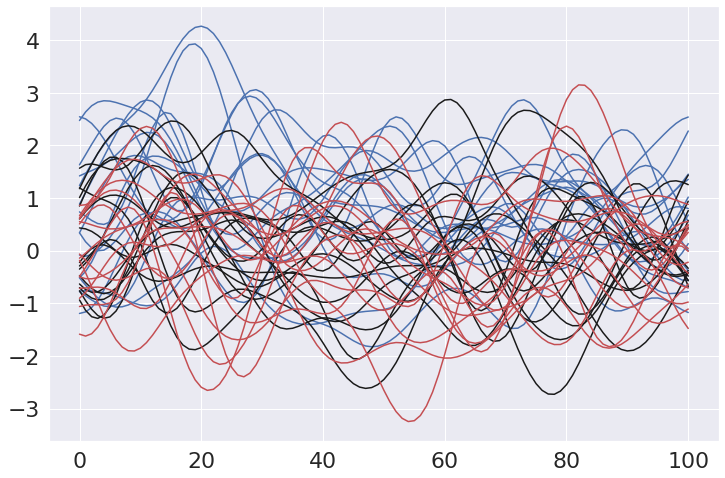

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(Y[A==0].T, 'b')
plt.plot(Y[A==1].T, 'k')
plt.plot(Y[A==2].T, 'r')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(Y[B==0].T, 'b')
plt.plot(Y[B==1].T, 'k')
plt.plot(Y[B==2].T, 'r')
plt.plot(Y[B==3].T, 'c')
plt.plot(Y[B==4].T, 'm')
plt.plot(Y[B==5].T, 'g')
plt.show()

In [ ]:
#(1) Conduct ANOVA:
alpha = 0.05
FF = spm1d.stats.anova2nested(Y, A, B, equal_var=True)
FFi = FF.inference(0.05)
print(FFi)

In [ ]:
#(2) Plot results:
plt.close('all')
plt.figure(figsize=(18, 12))
FFi.plot(plot_threshold_label=True, plot_p_values=True)
plt.show()

## Оффтопик: точный тест Фишера 

Цитата с Вики:


Точный тест(англ. exact test) — такой статистический критерий, при котором в ходе проверки гипотезы вероятность ошибки первого рода всегда равна уровню значимости. Соответственно, можно рассчитать точное p-значение (англ. exact p-value).

|  . | Мужчин | Женщин  | Всего  |
|---|---|---|---|
| Контрольная группа  | 8  |  7 |  15 |
| Инсульт  |  14 |  1 |  15 |
|  Всего  |  22 | 8  | 30  |

Мы тестируем гипотезу:

$$\mathbb{H}_0:~~\textrm{Пропорции мужчин и женщин в каждой группе равны}$$  $$~~\mathrm{vs}~~$$  $$\mathbb{H}_1: ~~ \textrm{не равны}$$

Тест считает все возможные способы разбросать 30 наблюдений по таблице 2 x 2 с такими же суммами по строкам и столбцам и с такими же пропорциями, как в таблице выше.

In [ ]:
from scipy.stats import fisher_exact

con_m, con_f = 8, 7
str_m, str_f = 14, 1

design_matrix = np.array([[con_m, con_f], [str_m, str_f]])

oddsratio, pvalue = fisher_exact([[con_m, con_f], [str_m, str_f]])


print('Fisher exact test p-value: {:.4f}'.format(pvalue))

p-value утверждает, что пропорции мужчин и женщин разные.

##### Второй вариант сделать тоже самое, но с R

`fisher_exact` из питона не поддерживает матрицы отличные от 2x2, поэтому если групп больше двух имеет смысл воспользоваться пакетом из R.

In [ ]:
!conda install -c anaconda libgfortran 

In [ ]:
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')

res = stats.fisher_test(design_matrix)
print ('p-value: {}'.format(res[0][0]))

In [ ]:
m = np.array([[4, 4], [4, 5],[10, 6]])

In [ ]:
fisher_exact(m)

In [ ]:
res = stats.fisher_test(m)
print ('p-value: {}'.format(res[0][0]))